# Environment

In [4]:
import random

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import ImageFont
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils.str_utils import get_common_hanzi
from utils.utils import convert_char_to_image

In [1]:
%cd ..

D:\PythonProjects\csc


# Datasets

In [5]:
class HanziImageDataset(Dataset):

    def __init__(self):
        super(HanziImageDataset, self).__init__()

        self.hanzi_list = list(get_common_hanzi())
        random.shuffle(self.hanzi_list)

        self.hanzi_image_cache = {}

    def __getitem__(self, index):
        hanzi = self.hanzi_list[index]
        if hanzi in self.hanzi_image_cache.keys():
            return self.hanzi_image_cache[hanzi]

        hanzi_image = convert_char_to_image(hanzi) / 255.
        self.hanzi_image_cache[hanzi] = hanzi_image
        return hanzi_image

    def __len__(self):
        return len(self.hanzi_list)

In [6]:
dataset = HanziImageDataset()

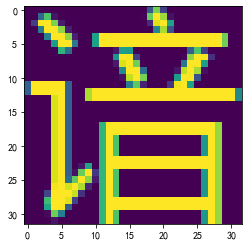

In [7]:
plt.imshow(dataset.__getitem__(0))

In [8]:
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Model

In [9]:
class DenseAutoEncoder(nn.Module):

    def __init__(self):
        super(DenseAutoEncoder, self).__init__()
        self.encoder =  nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(256, 56),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            nn.Linear(56, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.Sigmoid()
        )

    def forward(self, images):
        bs = images.size(0)
        images = images.view(bs, -1)
        return self.decoder(self.encoder(images)).view(bs, 32, 32)

In [10]:
model = DenseAutoEncoder()

# Train

In [11]:
loss_fnt = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
epochs = 50

model = model.train()
for epoch in range(epochs):
    progress = tqdm(dataloader, desc="Epoch %s" % epoch)
    total_loss = 0.
    step = 0
    for images_X in progress:
        bs = images_X.size(0)
        images_Y = model(images_X)

        images_X = images_X.view(bs, -1)
        images_Y = images_Y.view(bs, -1)

        loss = loss_fnt(images_Y, images_X)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        step += 1

        progress.set_postfix({
            "loss": total_loss / step
        })

Epoch 36:   5%|▍         | 42/846 [00:00<00:17, 45.63it/s, loss=0.079] 


KeyboardInterrupt: 

# Test

In [13]:
model = model.eval()

In [14]:
hanzi_X = dataset.__getitem__(random.randint(0, len(dataset)))

In [15]:
hanzi_Y = model(hanzi_X.unsqueeze(0))[0].detach()

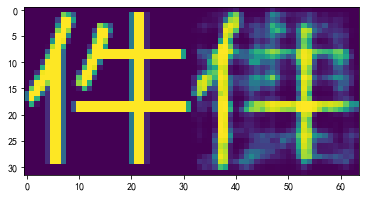

In [16]:
plt.imshow(torch.concat([hanzi_X, hanzi_Y], dim=1).detach().numpy())